In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision.datasets import MNIST
import torch
import random

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.datasets.mnist import Mnist


def plot_mnist_client_data(seeds, n_clients, alpha):
    train_data = MNIST(root='../data', train=True)
    dataset = Mnist(num_workers=0, public_fraction=0.5)

    fig, ax = plt.subplots(len(settings_files), 1, figsize=(16, 10))

    for j, seed in enumerate(seeds):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        dataset.generate_client_data(n_clients=10, distribution="niid", alpha=alpha)
        local_indices = dataset.get_local_sets_indices()
        
        client_targets = [train_data.targets[indices].tolist() for indices in local_indices]
        n_classes = 10

        label_count_matrix = np.array([[np.sum(np.array(client_targets[i]) == c) for c in range(10)] for i in range(n_clients)])
        data_dict = {}
        for i in range(n_classes):
            data_dict[f"label_count{i}"] = label_count_matrix[:, i]

        df = pd.DataFrame(data_dict)

        df.plot(ax=ax[j], kind='bar', stacked=True, rot=0)
        ax[j].get_legend().remove()
    ax[0].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.02,1,0.15), loc="upper left")
    plt.show()

def plot_test_public_data():

    dataset = Mnist(num_workers=0, public_fraction=0.5)
    public_indices = dataset.get_public_indices()

    test_data = MNIST(root='../data', train=False)
    train_data = MNIST(root='../data', train=True)
    test_public_targets = [test_data.targets.tolist()]
    test_public_targets.append(train_data.targets[public_indices].tolist())

    label_count_matrix = np.array([[np.sum(np.array(targets) == c) for c in range(10)] for targets in test_public_targets])

    n_classes = 10
    data_dict = {}
    for i in range(n_classes):
        data_dict[f"label_count{i}"] = label_count_matrix[:, i]

    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame(data_dict, index=["Test data", "Public data"])
    df.plot(ax=ax, kind='bar', stacked=True, rot=0)
    ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.01,1,0.1), loc="upper left")
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()    

def plot_client_training(settings_files, alg, weight_scheme, student_model=None, loss=None):    
    student_model = student_model + "_" if student_model is not None else ""
    loss = loss + "_" if loss is not None else ""

    dataset = settings_files[0].split('_')[0]
    
    fig, ax = plt.subplots(2, len(seeds), figsize=(15,6))
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}"
        client_accs = []
        with open(f"{results_path}/client_accuracy.npy", "rb") as f:
            try:
                while True:
                    client_accs.extend([np.load(f)])
            except:
                pass

        client_losses = []
        with open(f"{results_path}/client_loss.npy", "rb") as f:
            try:
                while True:
                    client_losses.extend([np.load(f)])
            except:
                pass

        for accs in client_accs:
            ax[0][i].plot(accs)

        for losses in client_losses:
            ax[1][i].plot(losses)
    plt.show()  

def plot_student_results(settings_files, n_pub, model, loss, weight_scheme):
    fig, ax = plt.subplots(len(settings_files), len(n_pub), figsize=(15,15))
    test_acc_lists = [[] for _ in range(len(n_pub))]
    ensemble_test_acc = [[] for _ in range(len(settings_files))]
    dataset = settings_files[0].split('_')[0]

    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/feded/{set}/w{weight_scheme}_student_mnist_{model}_{loss}"

        for j, n in enumerate(n_pub):
            with open(f"{results_path}_train_results_{n}.npy", "rb") as f:
                train_accs = np.load(f)
                train_losses = np.load(f)
                val_accs = np.load(f)
                val_losses = np.load(f)

            with open(f"{results_path}_test_results_{n}.npy", "rb") as f:
                test_results = np.load(f)

            ax[i][j].plot(train_accs)
            ax[i][j].plot(val_accs)
            ax[i][j].set_ylim([10,100])
            test_acc_lists[j].append(test_results[0])
            
        with open(f"../results/{dataset}/feded/{set}/w{weight_scheme}_ensemble_test_acc.npy", "rb") as f:
                ensemble_test_acc[i] = np.load(f)[0]
        
    plt.show()
    print("Test accuracy \n\n")
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10}".format('Run\Public size', n_pub[0], n_pub[1], n_pub[2], n_pub[3], n_pub[4], 'Ensemble'))
    for run in range(len(settings_files)):
        print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10} ".format(run, 
                                                  test_acc_lists[0][run],
                                                  test_acc_lists[1][run],
                                                  test_acc_lists[2][run],
                                                  test_acc_lists[3][run],
                                                               test_acc_lists[4][run],
                                                    ensemble_test_acc[run]))
    print("")
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Mean',
                                                     np.mean(test_acc_lists[0]),
                                                     np.mean(test_acc_lists[1]),
                                                     np.mean(test_acc_lists[2]),
                                                     np.mean(test_acc_lists[3]),
                                                                np.mean(test_acc_lists[4]),
                                                                np.mean(ensemble_test_acc)))
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Std',
                                                    np.std(test_acc_lists[0]),
                                                    np.std(test_acc_lists[1]),
                                                    np.std(test_acc_lists[2]),
                                                    np.std(test_acc_lists[3]),
                                                            np.std(test_acc_lists[4]),
                                                            np.std(ensemble_test_acc)))

def print_test_results(settings_files, alg):    
    #fig, ax = plt.subplots(1, 2, figsize=(15,6))
    dataset = settings_files[0].split('_')[0]
    test_acc_list = []
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}"

        with open(f"{results_path}/fedavg_test_results.npy", "rb") as f:
            test_accs = np.load(f)
            test_losses = np.load(f)

        #ax[0].plot(test_accs)
        #ax[1].plot(test_losses)
        test_acc_list.append(test_accs[-1])
    # ax[0].set_ylabel("Accuracy")
    # ax[0].set_xlabel("Communication round")
    # ax[1].set_ylabel("Loss")
    # ax[1].set_xlabel("Communication round")
    #plt.show()
    print("{:<8} {:<10}".format('Run', 'Test accuracy'))
    for run in range(len(settings_files)):
        print("{:<8} {:<10}".format(run, test_acc_list[run]))
    print("")
    print("{:<8} {:<10.2f}".format('Mean', np.mean(test_acc_list)))
    print("{:<8} {:<10.2f}".format('Std', np.std(test_acc_list)))
                                                

In [7]:
distribution = "niid0.01"
seeds = [1,2,3,4,5,6,7,8,9,10]
n_clients = 10
model = "mnist_cnn1"
settings_files = [f"{model}_c{n_clients}_{distribution}_s{i}" for i in seeds]

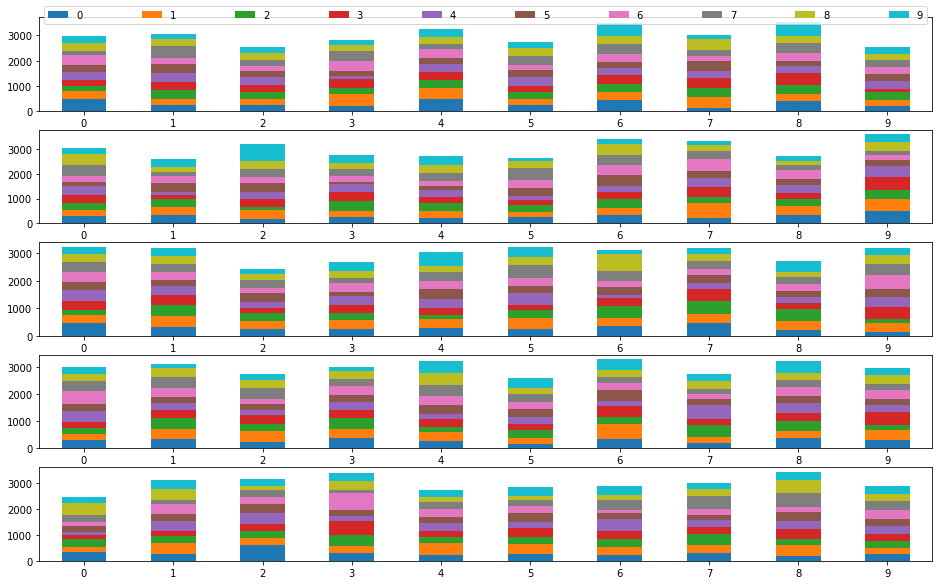

In [6]:
#plot_mnist_client_data(settings_files)
plot_mnist_client_data(seeds, n_clients, 10.0)

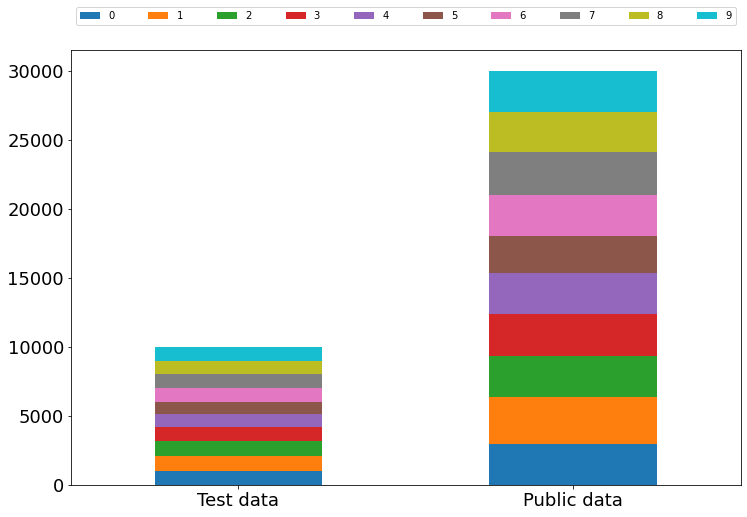

In [8]:
plot_test_public_data()

# FedAVG
```
class Mnist_Cnn(nn.Module):
    def __init__(self):
        super(Mnist_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(2 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
```

Centralized model ~ 94-95 % accuracy

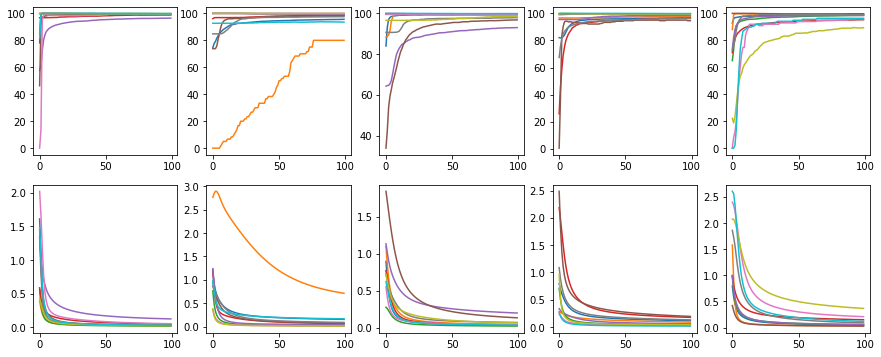

In [3]:
plot_client_training(settings_files, "fedavg", 0)

In [8]:
print_test_results(settings_files, "fedavg")

Run      Test accuracy
0        89.08     
1        87.96     
2        87.5      
3        86.67     
4        89.01     
5        85.97     
6        88.34     
7        88.37     
8        89.93     
9        90.89     

Mean     88.37     
Std      1.39      


In [5]:
print_test_results(settings_files, "fedprox")

Run      Test accuracy
0        95.01     
1        93.16     
2        93.47     
3        93.59     
4        93.87     

Mean     93.82     
Std      0.64      


# FedED
```
class Mnist_Cnn2(nn.Module):
    def __init__(self):
        super(Mnist_Cnn2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
loss = nn.MSELoss()
```

$$
  \mathbf{\hat{z}} = \sum_{k\in\mathcal{K}_t} \omega_k \mathbf{z}^k, \quad \omega^k = \frac{N^k}{\sum_{k\in\mathcal{K}_t} N^k}
$$

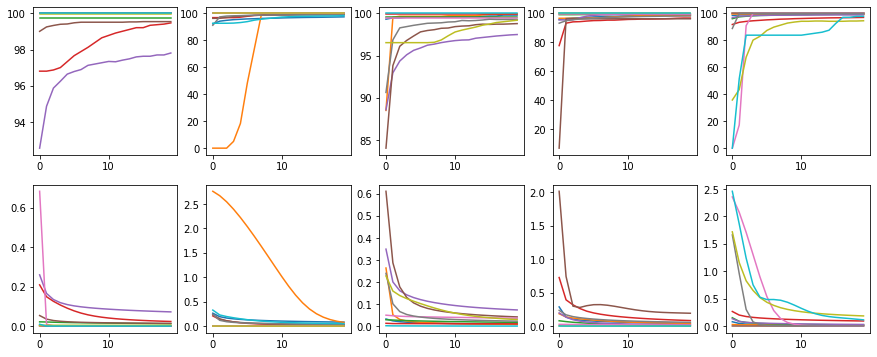

In [5]:
plot_client_training(settings_files, "feded", 0, "cnn1", "mse")

mnist_cnn1_c10_niid0.01_s6
mnist_cnn1_c10_niid0.01_s7
mnist_cnn1_c10_niid0.01_s8
mnist_cnn1_c10_niid0.01_s9
mnist_cnn1_c10_niid0.01_s10


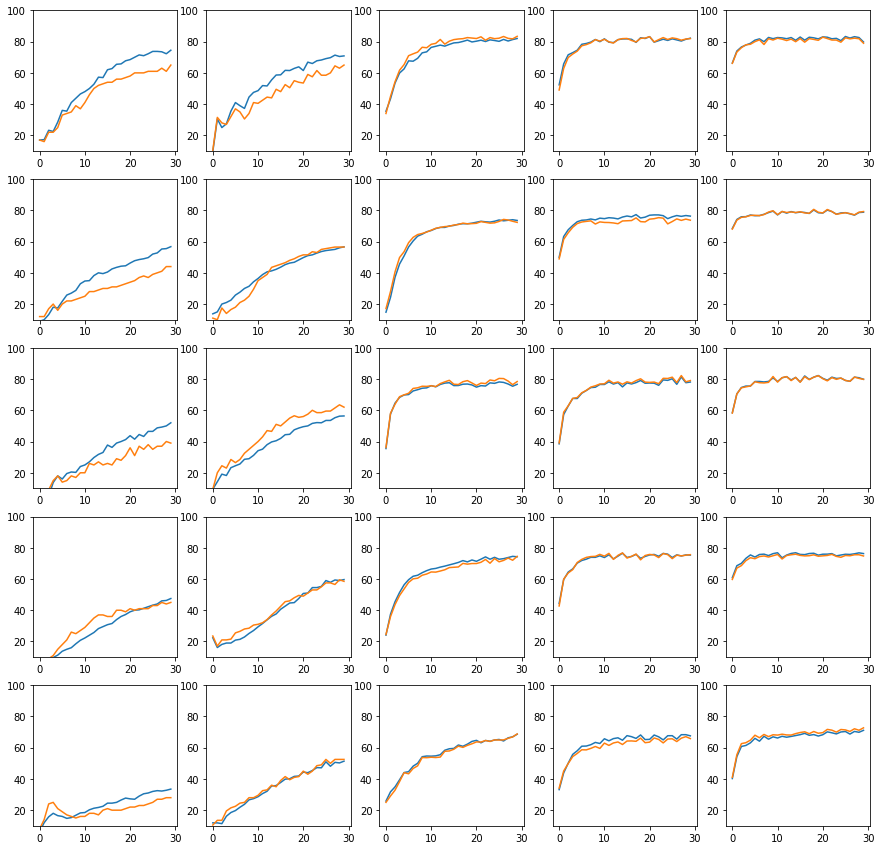

Test accuracy 


Run\Public size 500        1000       5000       15000      30000      | Ensemble  
0               23.32      24.49      27.72      29.5       31.3       | 27.4       
1               31.36      34.7       40.58      43.58      44.24      | 44.65      
2               25.98      32.56      34.9       34.78      35.39      | 33.01      
3               34.56      35.64      44.71      43.73      44.46      | 41.91      
4               29.71      31.75      42.45      42.02      41.18      | 35.61      

Mean            28.99      31.83      38.07      38.72      39.31      36.52     
Std             3.96       3.93       6.11       5.66       5.17       6.19      


In [6]:
plot_student_results(settings_files, [500, 1000, 5000, 15000, 30000], "cnn1", "mse", 0)

# FedED weight scheme 1

$$
  \mathbf{\hat{z}}_c = \sum_{k\in\mathcal{K}_t} \omega^c_k \mathbf{z}^k_c, \quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$

In [36]:
#plot_client_training("mnist", "feded", 1, "cnn2")

mnist_cnn1_c10_niid0.01_s1
mnist_cnn1_c10_niid0.01_s2
mnist_cnn1_c10_niid0.01_s3
mnist_cnn1_c10_niid0.01_s4
mnist_cnn1_c10_niid0.01_s5
mnist_cnn1_c10_niid0.01_s6
mnist_cnn1_c10_niid0.01_s7
mnist_cnn1_c10_niid0.01_s8
mnist_cnn1_c10_niid0.01_s9
mnist_cnn1_c10_niid0.01_s10


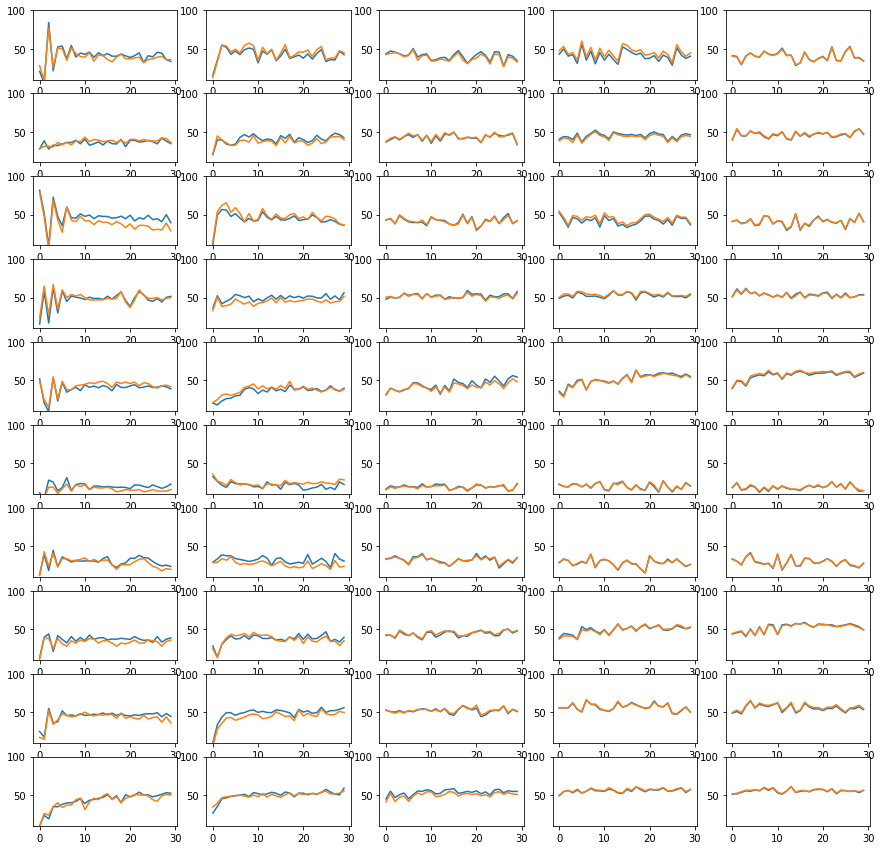

Test accuracy 


Run\Public size 500        1000       5000       15000      30000      | Ensemble  
0               31.92      33.54      37.32      38.94      42.3       | 16.8       
1               28.47      28.49      26.79      33.73      34.03      | 46.25      
2               35.33      40.03      36.57      39.63      37.27      | 23.47      
3               31.48      34.79      34.95      38.87      37.04      | 29.86      
4               27.74      35.31      42.29      37.49      34.72      | 48.9       
5               20.55      19.68      24.26      28.33      30.92      | 29.7       
6               25.82      28.45      30.02      35.77      35.86      | 29.5       
7               27.94      28.81      34.06      32.16      37.74      | 47.73      
8               34.23      39.59      42.29      39.96      36.68      | 46.23      
9               35.6       40.14      38.18      42.48      40.23      | 62.66      

Mean            29.91      32.88      34.67     

In [3]:
plot_student_results(settings_files, [500, 1000, 5000, 15000, 30000], "cnn2", "mse", 1)

# FedED weight scheme 2

1. Träna autoencoder $H_k$ på privat data $\mathcal{D}_k$.
2. För varje publikt dataexempel $x_j$, notera loss
$$ l_k(x_j) = MSE(H_k(x_j), x_j). $$
3. Ange vikt 
$$\omega^j_k = \frac{1}{l_k(x_j)^6}.$$
3. Bilda viktat medelvärde för logits med aktiva klienter $\mathcal{K}_t$
$$
  \mathbf{\hat{z}}_j = \sum_{k\in\mathcal{K}_t} \omega^j_k \mathbf{z}^j_k. %\quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$
4. Normalisera.

Student loss: 
$$\mathbf{z}_j = F_S(x_j) \qquad MSE(\mathbf{z}_j, \mathbf{\hat{z}}_j)$$
<!-- $$
  \mathbf{\bar{z}}_c = \sum_{k\in\mathcal{K}_t} N_c^k \mathbf{z}^k_c \\
  \mathbf{\hat{z}}_c = \frac{\mathbf{\bar{z}}_c}{\sum_c \mathbf{\bar{z}}_c}
$$ -->

mnist_cnn1_c10_niid0.01_s1
mnist_cnn1_c10_niid0.01_s2
mnist_cnn1_c10_niid0.01_s3
mnist_cnn1_c10_niid0.01_s4
mnist_cnn1_c10_niid0.01_s5
mnist_cnn1_c10_niid0.01_s6
mnist_cnn1_c10_niid0.01_s7
mnist_cnn1_c10_niid0.01_s8
mnist_cnn1_c10_niid0.01_s9
mnist_cnn1_c10_niid0.01_s10


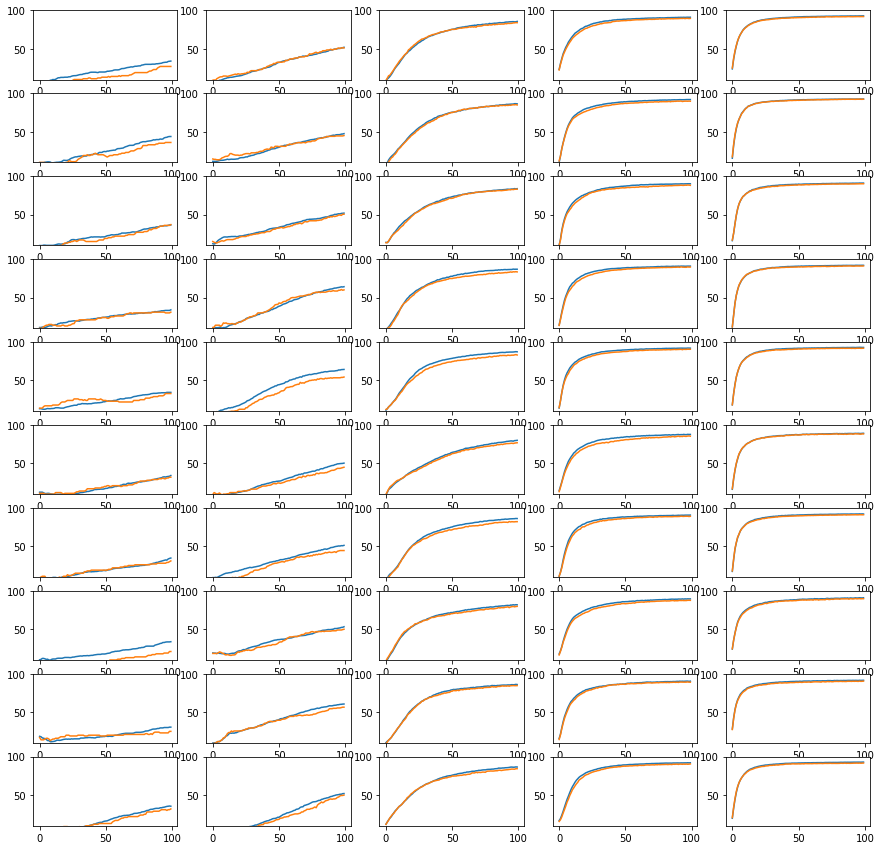

Test accuracy 


Run\Public size 500        1000       5000       15000      30000      | Ensemble  
0               26.28      47.64      82.71      90.39      92.0       | 92.85      
1               35.33      42.1       84.81      92.21      93.81      | 94.09      
2               33.73      46.54      82.0       89.58      90.99      | 91.91      
3               29.32      59.78      84.53      91.18      91.63      | 92.66      
4               28.48      58.71      85.38      92.32      93.42      | 94.3       
5               24.01      42.87      75.96      86.82      88.84      | 89.86      
6               23.11      47.49      83.0       90.13      91.84      | 92.74      
7               26.82      48.04      79.15      88.62      90.84      | 92.67      
8               25.0       52.06      82.71      88.57      90.02      | 92.33      
9               29.61      47.79      84.49      91.98      93.61      | 93.94      

Mean            28.17      49.30      82.47     

In [4]:
plot_student_results(settings_files, [500, 1000, 5000, 15000, 30000], "cnn2", "mse", 2)


Student loss: 
$$CE(\mathbf{t}_j, \mathbf{\hat{t}}_j)$$

mnist_cnn1_c10_niid0.01_s1
mnist_cnn1_c10_niid0.01_s2
mnist_cnn1_c10_niid0.01_s3
mnist_cnn1_c10_niid0.01_s4
mnist_cnn1_c10_niid0.01_s5
mnist_cnn1_c10_niid0.01_s6
mnist_cnn1_c10_niid0.01_s7
mnist_cnn1_c10_niid0.01_s8
mnist_cnn1_c10_niid0.01_s9
mnist_cnn1_c10_niid0.01_s10


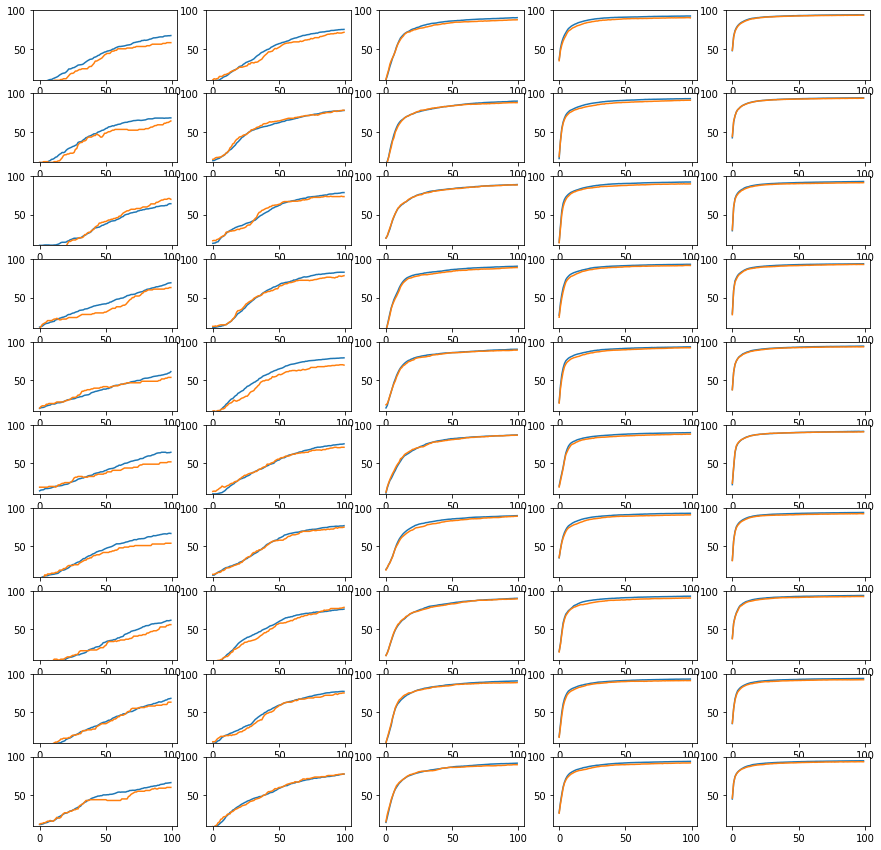

Test accuracy 


Run\Public size 500        1000       5000       15000      30000      | Ensemble  
0               54.95      67.6       88.72      92.18      93.83      | 92.85      
1               59.35      71.32      88.7       93.06      95.1       | 94.09      
2               55.08      70.78      88.58      92.37      93.44      | 91.91      
3               55.89      76.09      89.54      92.8       93.77      | 92.66      
4               49.03      72.4       89.76      93.68      94.72      | 94.3       
5               48.46      70.68      88.06      90.54      92.09      | 89.86      
6               55.59      68.76      88.71      92.81      93.95      | 92.74      
7               51.64      72.23      89.9       92.95      94.2       | 92.67      
8               54.71      67.87      88.3       91.77      92.89      | 92.33      
9               55.76      71.02      89.56      93.73      95.08      | 93.94      

Mean            54.05      70.88      88.98     

In [5]:
plot_student_results(settings_files, [500, 1000, 5000, 15000, 30000], "cnn2", "ce", 2)